In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import FancyArrowPatch
from matplotlib.lines import Line2D

In [94]:
data = {
    'from': [1, 2, 3, 4, 2, 2, 4, 6, 8],
    'to': [1, 2, 3, 4, 1, 3, 2, 5, 7]
}
df = pd.DataFrame(data)

In [116]:
df

,from,to
0,1,1
1,2,2
2,3,3
3,4,4
4,2,1
5,2,3
6,4,2
7,6,5
8,8,7


In [ ]:
def link_doublet(df: pd.DataFrame, loop_color='red', edge_color='black', inter_edge_color='blue', background_color='white', title='', color_title='black'):
    # creating a graph
    G = nx.DiGraph()
    G.add_nodes_from(pd.concat([df['from'], df['to']]).unique())
    edges = list(zip(df['from'], df['to']))
    G.add_edges_from(edges)

    # node positions
    pos = nx.circular_layout(G)

    fig, ax = plt.subplots(figsize=(12, 8))
    fig.patch.set_facecolor(background_color)
    ax.set_facecolor(background_color)

    # dictionaries for storing arrow positions
    operation_positions = {}

    # number of closed connections
    loops = df[df['from'] == df['to']]
    loop_nodes = set(loops['from'])
    max_loop_id = len(loops)

    for i, row in df.iterrows():
        src, dst = row['from'], row['to']
        op_id = i + 1  # operation ID = line number + 1

        # if it's a closed loop
        if src == dst:
            def draw_infinity_loop(ax, x, y, label_id=None, size=0.12, color=loop_color):
                t = np.linspace(0, 2 * np.pi, 500)
                a = size
                x_loop = a * np.sin(t) / (1 + np.cos(t)**2)
                y_loop = a * np.sin(t) * np.cos(t) / (1 + np.cos(t)**2)
                x_loop += x
                y_loop += y
                ax.plot(x_loop, y_loop, color=color, lw=2)

                arrow_idx = -20
                arrow = FancyArrowPatch(
                    (x_loop[arrow_idx], y_loop[arrow_idx]),
                    (x_loop[arrow_idx + 1], y_loop[arrow_idx + 1]),
                    arrowstyle='->', color=color, mutation_scale=15, lw=2
                )
                ax.add_patch(arrow)

                if label_id is not None:
                    ax.text(x, y - 0.10, str(label_id),
                            fontsize=10, color=color, ha='center', va='center', zorder=5)

            x, y = pos[src]
            draw_infinity_loop(ax, x, y, label_id=op_id)

        # if it's a regular arrow between loops
        elif src in loop_nodes and dst in loop_nodes:
            x1, y1 = pos[src]
            x2, y2 = pos[dst]

            arrow = FancyArrowPatch(
                (x1, y1), (x2, y2),
                arrowstyle='->', color=edge_color,
                mutation_scale=20, lw=2
            )
            ax.add_patch(arrow)

            # a cross at the beginning
            dx, dy = x2 - x1, y2 - y1
            length = np.hypot(dx, dy)
            if length != 0:
                ux, uy = dx / length, dy / length
                perp_x, perp_y = -uy, ux
                cross_length = 0.03 # crosshair length
                start_x = x1 + ux * 0.07 # 0.07 - distance from the beginning
                start_y = y1 + uy * 0.07
                line = Line2D(
                    [start_x - perp_x * cross_length, start_x + perp_x * cross_length],
                    [start_y - perp_y * cross_length, start_y + perp_y * cross_length],
                    color=edge_color, lw=2, zorder=1
                )
                ax.add_line(line)

            # signature of the operation ID
            mid_x = (x1 + x2) / 2
            mid_y = (y1 + y2) / 2
            ax.text(mid_x + 0.03, mid_y + 0.03, str(op_id),
                    fontsize=10, color=edge_color, ha='left', va='bottom', zorder=5)

            # memorizing the middle of this arrow for possible further connections
            operation_positions[op_id] = ((x1, y1), (x2, y2))

        # otherwise, this is the connection between the operations (arrows)
        else:
            # where from and where to - these are the operation IDs
            from_op = src
            to_op = dst

            if from_op in operation_positions and to_op in operation_positions:
                (x1_start, y1_start), (x1_end, y1_end) = operation_positions[from_op]
                (x2_start, y2_start), (x2_end, y2_end) = operation_positions[to_op]

                # we take the middle of the arrows
                mid1_x, mid1_y = (x1_start + x1_end) / 2, (y1_start + y1_end) / 2
                mid2_x, mid2_y = (x2_start + x2_end) / 2, (y2_start + y2_end) / 2

                # we will automatically determine the direction of the radius (up/down)
                rad = 0.9
                if mid1_y > mid2_y:
                  rad = -0.9  # if the first one is higher than the second one, we bend the arc down
                else:
                  rad = 0.9   # otherwise up

                arrow = FancyArrowPatch(
                  (mid1_x, mid1_y), (mid2_x, mid2_y),
                  connectionstyle=f"arc3,rad={rad}",  # new bend
                  arrowstyle='->', color=inter_edge_color,
                  mutation_scale=20, lw=2
                )
                ax.add_patch(arrow)

                # signature of the operation ID
                # the center is between the beginning and the end
                mid_x = (mid1_x + mid2_x) / 2
                mid_y = (mid1_y + mid2_y) / 2

                # vector direction from mid1 to mid2
                dx = mid2_x - mid1_x
                dy = mid2_y - mid1_y
                length = np.hypot(dx, dy)

                # perpendicular vector (normalized)
                perp_dx = -dy / length
                perp_dy = dx / length

                # offset along the perpendicular
                curvature = abs(rad)
                offset_magnitude = curvature * 0.3  # adjust the value for yourself
                offset_x = perp_dx * offset_magnitude
                offset_y = perp_dy * offset_magnitude

                # a new center, taking into account the bend
                arc_mid_x = mid_x + offset_x
                arc_mid_y = mid_y + offset_y

                ax.text(arc_mid_x, arc_mid_y, str(op_id),
                        fontsize=10, color=inter_edge_color, ha='center', va='center', zorder=5)

    ax.set_aspect('equal')
    ax.axis('off')
    plt.title(title, color=color_title)
    plt.tight_layout()
    plt.show()

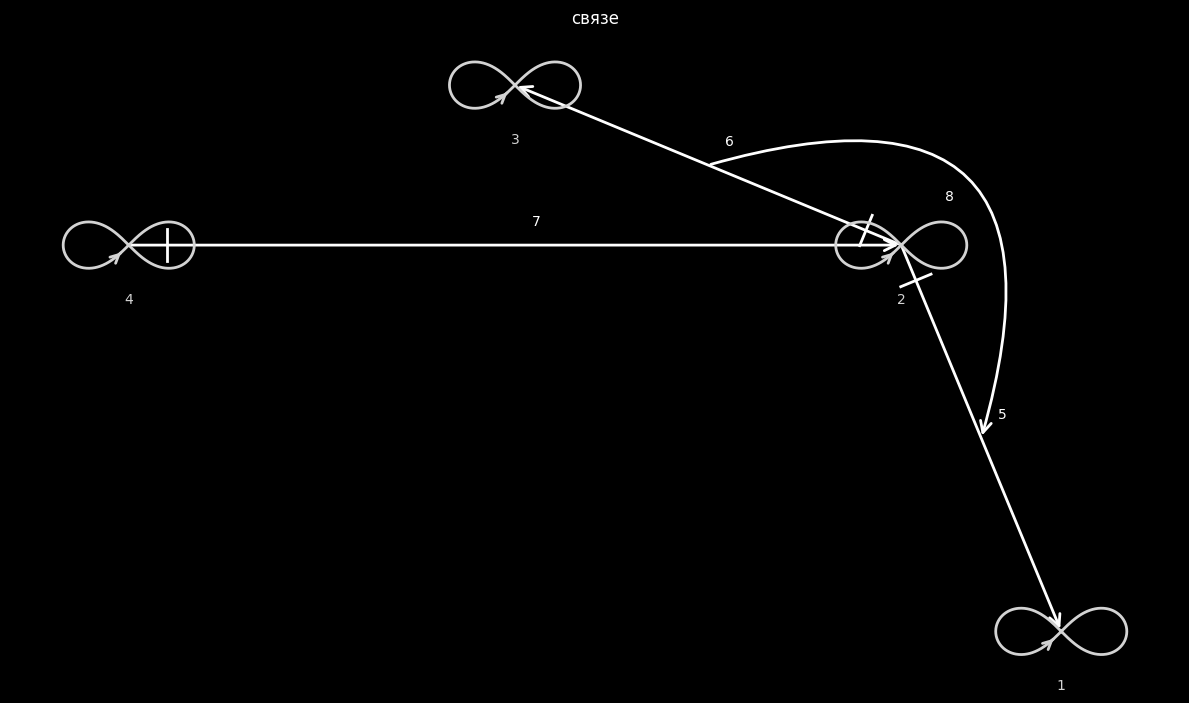

In [ ]:
link_doublet(df, loop_color='lightgray', edge_color='white', inter_edge_color='white', background_color='black', title='связе', color_title='white')